In [1]:
import rapids_singlecell as rsc

In [3]:
import scanpy as sc 
import pandas as pd
import numpy as np
from scipy.stats import median_abs_deviation
import os
import warnings
warnings.filterwarnings('ignore', 'Expected')
warnings.simplefilter('ignore')


import anndata
from anndata import AnnData
import matplotlib

import time
import cuda
import cudf
import cupy

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler



In [4]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=True,
)

cupy.cuda.set_allocator(rmm_cupy_allocator)

In [5]:
print(sc.__dir__())

['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', '_version', '__version__', 'logging', '_settings', '_utils', '_compat', 'settings', 'Verbosity', 'get', 'neighbors', 'preprocessing', 'readwrite', 'tools', 'tl', 'pp', 'plotting', 'pl', 'datasets', 'queries', 'external', 'metrics', 'experimental', 'AnnData', 'concat', 'read_h5ad', 'read_csv', 'read_excel', 'read_hdf', 'read_loom', 'read_mtx', 'read_text', 'read_umi_tools', 'read', 'read_10x_h5', 'read_10x_mtx', 'write', 'read_visium', 'Neighbors', 'set_figure_params']


In [6]:
print(rmm.__file__)
print(rmm.__path__)
print(rmm.__dir__())
print(rsc.__dir__())
print(rsc.__file__)
print(anndata.__dir__())




/home/supakorn/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/rmm/__init__.py
['/home/supakorn/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/rmm']
['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', '_cuda', '_lib', 'mr', 'DeviceBuffer', 'flush_logger', 'get_flush_level', 'get_logging_level', 'logging_level', 'set_flush_level', 'set_logging_level', 'should_log', '_version', '__git_commit__', '__version__', 'disable_logging', 'enable_logging', 'get_log_filenames', 'rmm', 'RMMError', 'is_initialized', 'register_reinitialize_hook', 'reinitialize', 'unregister_reinitialize_hook', '__all__', 'allocators']
['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__path__', '__file__', '__cached__', '__builtins__', 'cunnData', 'decoupler_gpu', 'dcg', 'squidpy_gpu', 'gr', 'tools', 'preprocessing', 'pp', 'tl', 'utils', 'get', '_version', '__version__']
/home/supakorn/miniconda3/envs/rapids-24.02/l

In [7]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2024-03-15 17:13:57.220935: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 17:13:57.267118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 17:13:57.267165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 17:13:57.268263: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-15 17:13:57.275442: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.9.8 anndata==0.10.6 umap==0.5.5 numpy==1.24.4 scipy==1.12.0 pandas==1.5.3 scikit-learn==1.4.1.post1 statsmodels==0.14.1 pynndescent==0.5.11


In [8]:
results_file = "/home/supakorn/rscript/GSE184950/GSE184950_test.h5ad"

In [9]:
directory = '/home/supakorn/rscript/GSE184950/data/'
dirs = os.listdir(directory)
print(dirs)

['GSM5602344_p4_CTL_female_filtered_feature_bc_matrix', 'GSM5602327_B5_CTL_female_filtered_feature_bc_matrix', 'GSM5602335_C8_CTL_female_filtered_feature_bc_matrix', 'GSM5602323_B19_PDD_female_filtered_feature_bc_matrix', 'GSM5602339_D29_PDD_male_filtered_feature_bc_matrix', 'GSM5602318_A2_CTL_female_filtered_feature_bc_matrix', 'GSM5602331_C18_PD_female_filtered_feature_bc_matrix', 'GSM5602329_C1_CTL_male_filtered_feature_bc_matrix', 'GSM5602322_B13_PDD_male_filtered_feature_bc_matrix', 'GSM5602317_A18_PDD_male_filtered_feature_bc_matrix', 'GSM5602326_B33_PDD_female_filtered_feature_bc_matrix', 'GSM5602316_A15_PDD_male_filtered_feature_bc_matrix', 'GSM5602320_A31_PDD_female_filtered_feature_bc_matrix', 'GSM5602338_D27_PD_male_filtered_feature_bc_matrix', 'GSM5602324_B25_PD_female_filtered_feature_bc_matrix', 'GSM5602345_p5_CTL_female_filtered_feature_bc_matrix', 'GSM5602328_B9_CTL_male_filtered_feature_bc_matrix', 'GSM5602330_C11_PD_male_filtered_feature_bc_matrix', 'GSM5602319_A29_PD

### **Create AnnData object**

In [10]:
dfs = []

patient_adata_list = []

for filename in dirs:
    
    name = filename.replace('_filtered_feature_bc_matrix', '').split('_')
    Patient = name[1]
    Type = name[2]
    
    matrix_file = os.path.join(directory, filename)
    
    adata = sc.read_10x_mtx(matrix_file,
                            var_names='gene_symbols')
    
    adata.var_names_make_unique()
    
    patient_adata_list.append(adata)
        
    adata.obs['Patient'] = Patient
    adata.obs['Type'] = Type
    
    df = pd.DataFrame(adata.obs)
    
    dfs.append(df)
    
merge_df = pd.concat(dfs)



--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

In [11]:
merged_adata = anndata.concat(patient_adata_list, join='outer', merge='same')

In [12]:
print(merged_adata.obs.value_counts())
print(merged_adata.obs.Patient)

Patient  Type
A29      PDD     27603
A38      PDD     22577
C20      PD      21450
C18      PD      19620
D27      PD      19263
A31      PDD     18841
p5       CTL     18829
B19      PDD     18811
A22      PDD     18139
A18      PDD     17752
D20      PDD     15832
D16      PDD     14933
p4       CTL     14068
D29      PDD     13202
C26      PDD     12615
A15      PDD     11760
D33      PDD     11738
A2       CTL     11055
C8       CTL     10243
C11      PD       9683
C1       CTL      7804
B33      PDD      7489
B9       CTL      7421
p12      PD       6508
B25      PD       6356
B28      PDD      6193
B5       CTL      5017
D3       CTL      4782
B13      PDD      3608
A10      CTL      2165
dtype: int64
AAACCCAAGGCCACTC-1     p4
AAACCCAAGTATGATG-1     p4
AAACCCAAGTCCCAGC-1     p4
AAACCCAAGTGCCAGA-1     p4
AAACCCAAGTTTCGGT-1     p4
                     ... 
TTTGTTGGTATCTTCT-1    D20
TTTGTTGGTATGGTTC-1    D20
TTTGTTGGTTACGATC-1    D20
TTTGTTGTCCCAGCGA-1    D20
TTTGTTGTCGTTCGCT-1    D

In [13]:
merged_adata

AnnData object with n_obs × n_vars = 385357 × 33538
    obs: 'Patient', 'Type'
    var: 'gene_ids', 'feature_types'

In [62]:
rsc.get.anndata_to_GPU(merged_adata)

#In case to move back to CPU
#rsc.get.anndata_to_CPU(merged_adata)

In [15]:
merged_adata.var["mt"] = merged_adata.var_names.str.startswith("MT-")

rsc.pp.calculate_qc_metrics(
    merged_adata, qc_vars=["mt"], 
    log1p=True)

In [16]:
merged_adata

AnnData object with n_obs × n_vars = 385357 × 33538
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

### **Plot QC**

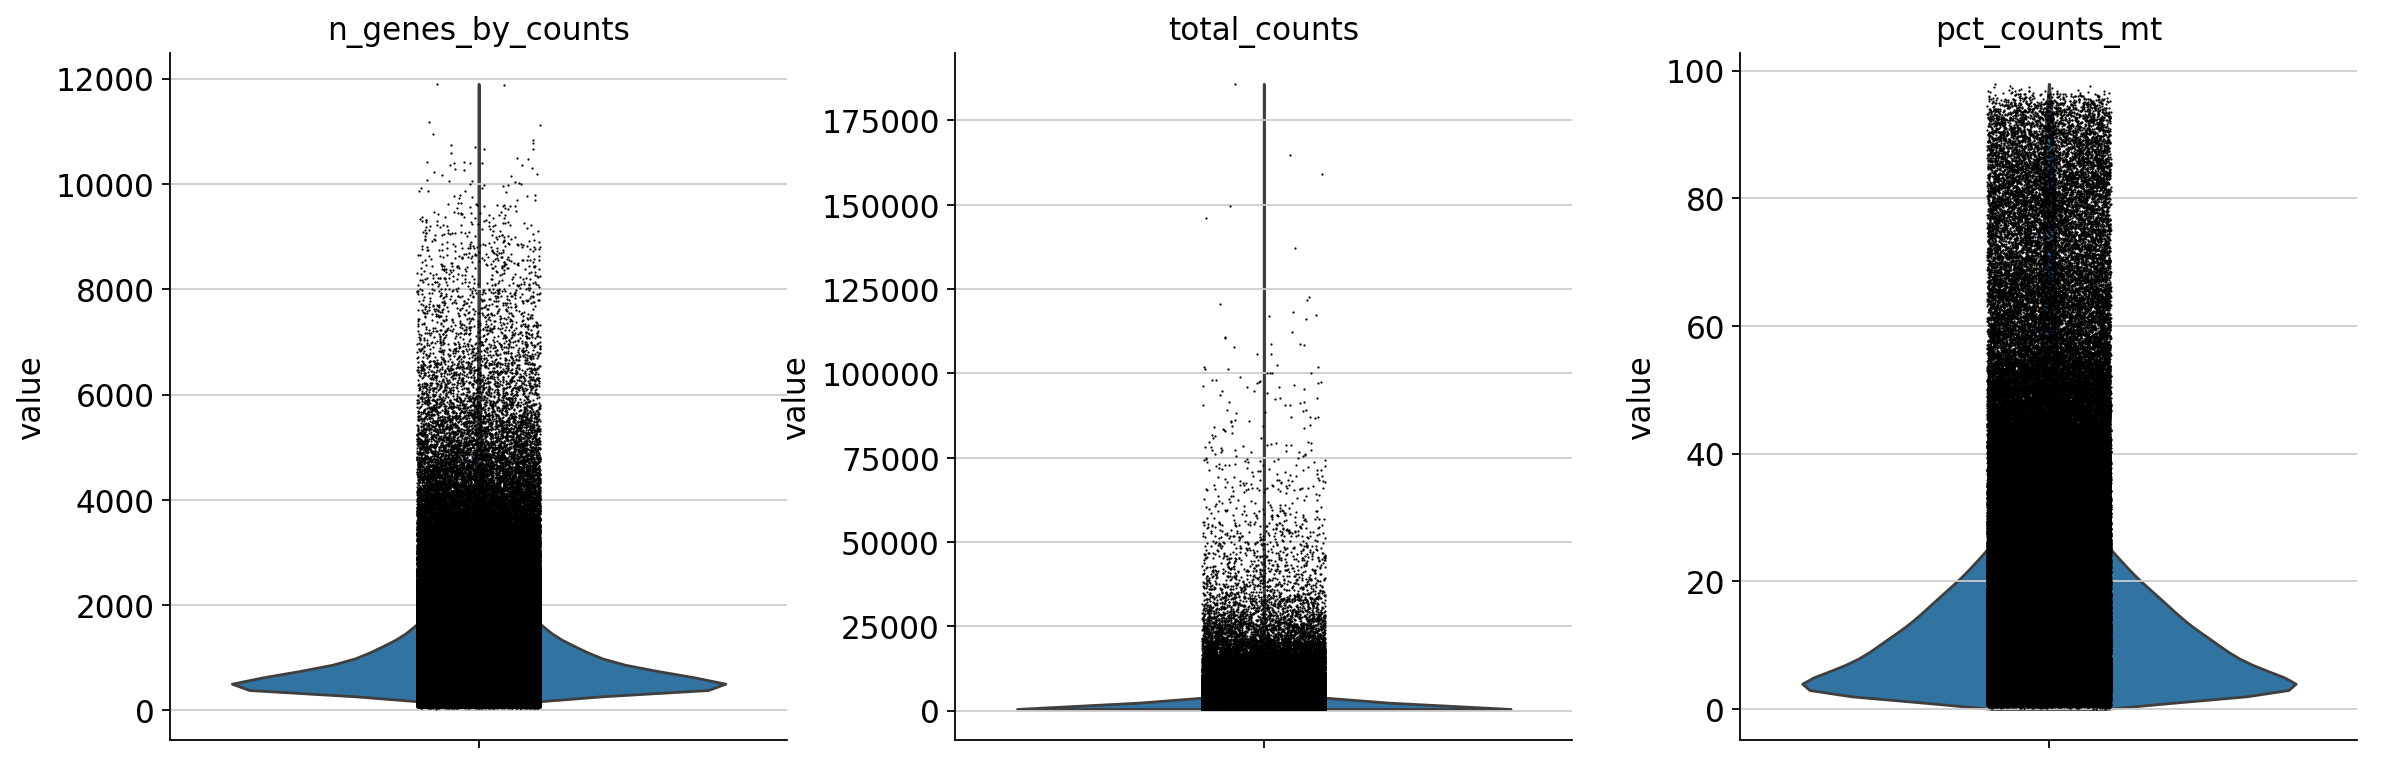

In [17]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.1,
    multi_panel=True)

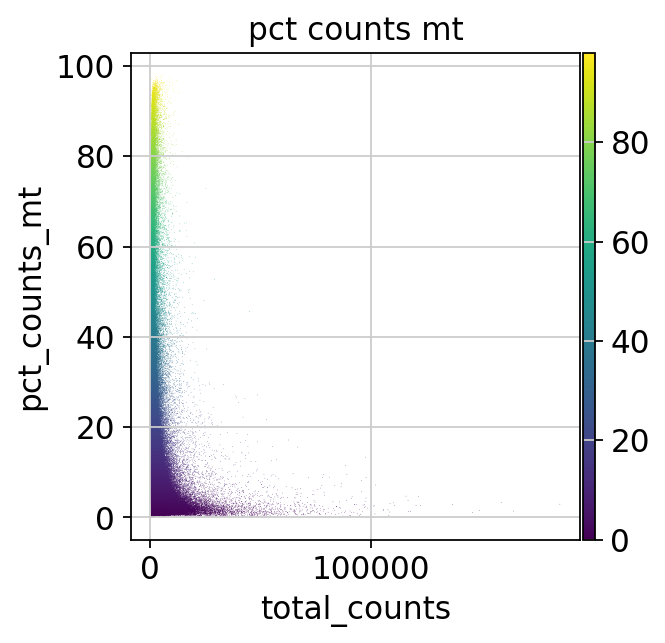

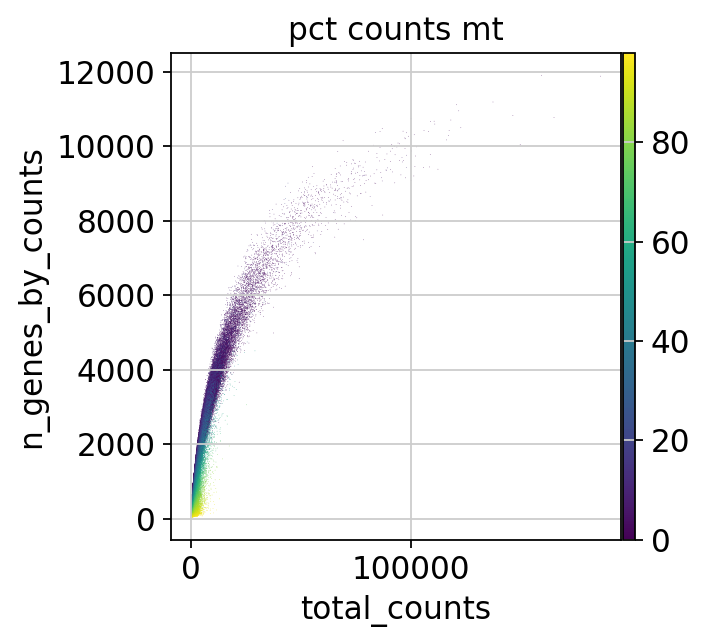

In [18]:
sc.pl.scatter(merged_adata, x="total_counts", y="pct_counts_mt", color="pct_counts_mt")
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

## **Outlier Threshold**

### ***MAD = median(|Xi - median(X)|)***
Xi is the respective QC metric of an observation and 
describes a robust statistic of the variability of the metric.
[Germain et al., 2020]

In [19]:
def is_outlier(merged_adata, metric: str, nmads: int):
    M = merged_adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [20]:
merged_adata.obs["outlier"] = (
    is_outlier(merged_adata, "log1p_total_counts", 5) |
    is_outlier(merged_adata, "log1p_n_genes_by_counts", 5) #|
    #is_outlier(merged_adata, "pct_counts_in_top_20_genes", 5)   
)
merged_adata.obs.outlier.value_counts()

False    383714
True       1643
Name: outlier, dtype: int64

In [21]:
merged_adata.obs["mt_outlier"] = is_outlier(merged_adata, "pct_counts_mt", 3) | (
    merged_adata.obs["pct_counts_mt"] > 20
)
merged_adata.obs.mt_outlier.value_counts()

False    271847
True     113510
Name: mt_outlier, dtype: int64

In [22]:
print(f"Total number of cells: {merged_adata.n_obs}")
merged_adata = merged_adata[(~merged_adata.obs.outlier) & (~merged_adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {merged_adata.n_obs}")

Total number of cells: 385357
Number of cells after filtering of low quality cells: 270305


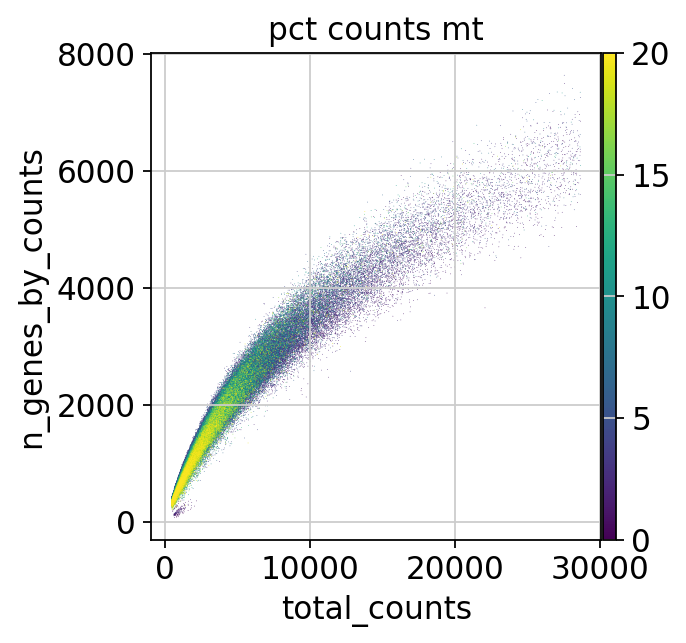

In [23]:
sc.pl.scatter(merged_adata, x="total_counts", y="n_genes_by_counts", color="pct_counts_mt")

### **Filtering**

In [25]:
print(f"Total number of genes: {merged_adata.n_vars}")
rsc.pp.filter_genes(merged_adata, min_count=3)
print(f"Number of genes after cell filter: {merged_adata.n_vars}")

#sc.pp.filter_cells(merged_adata, max_genes=5000)
#merged_adata = merged_adata[merged_adata.obs.pct_counts_mt < 20, :]
#merged_adata = merged_adata[merged_adata.obs.total_counts < 20000, :]
#merged_adata = merged_adata[merged_adata.obs.total_counts > 300, :]

Total number of genes: 33538
filtered out 4123 genes based on n_cells_by_counts
Number of genes after cell filter: 29415


In [26]:
merged_adata

AnnData object with n_obs × n_vars = 270305 × 29415
    obs: 'Patient', 'Type', 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_total_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts'

### **Plot after filtering**

In [ ]:
# Switch to CPU for plotting
rsc.get.anndata_to_CPU(merged_adata)

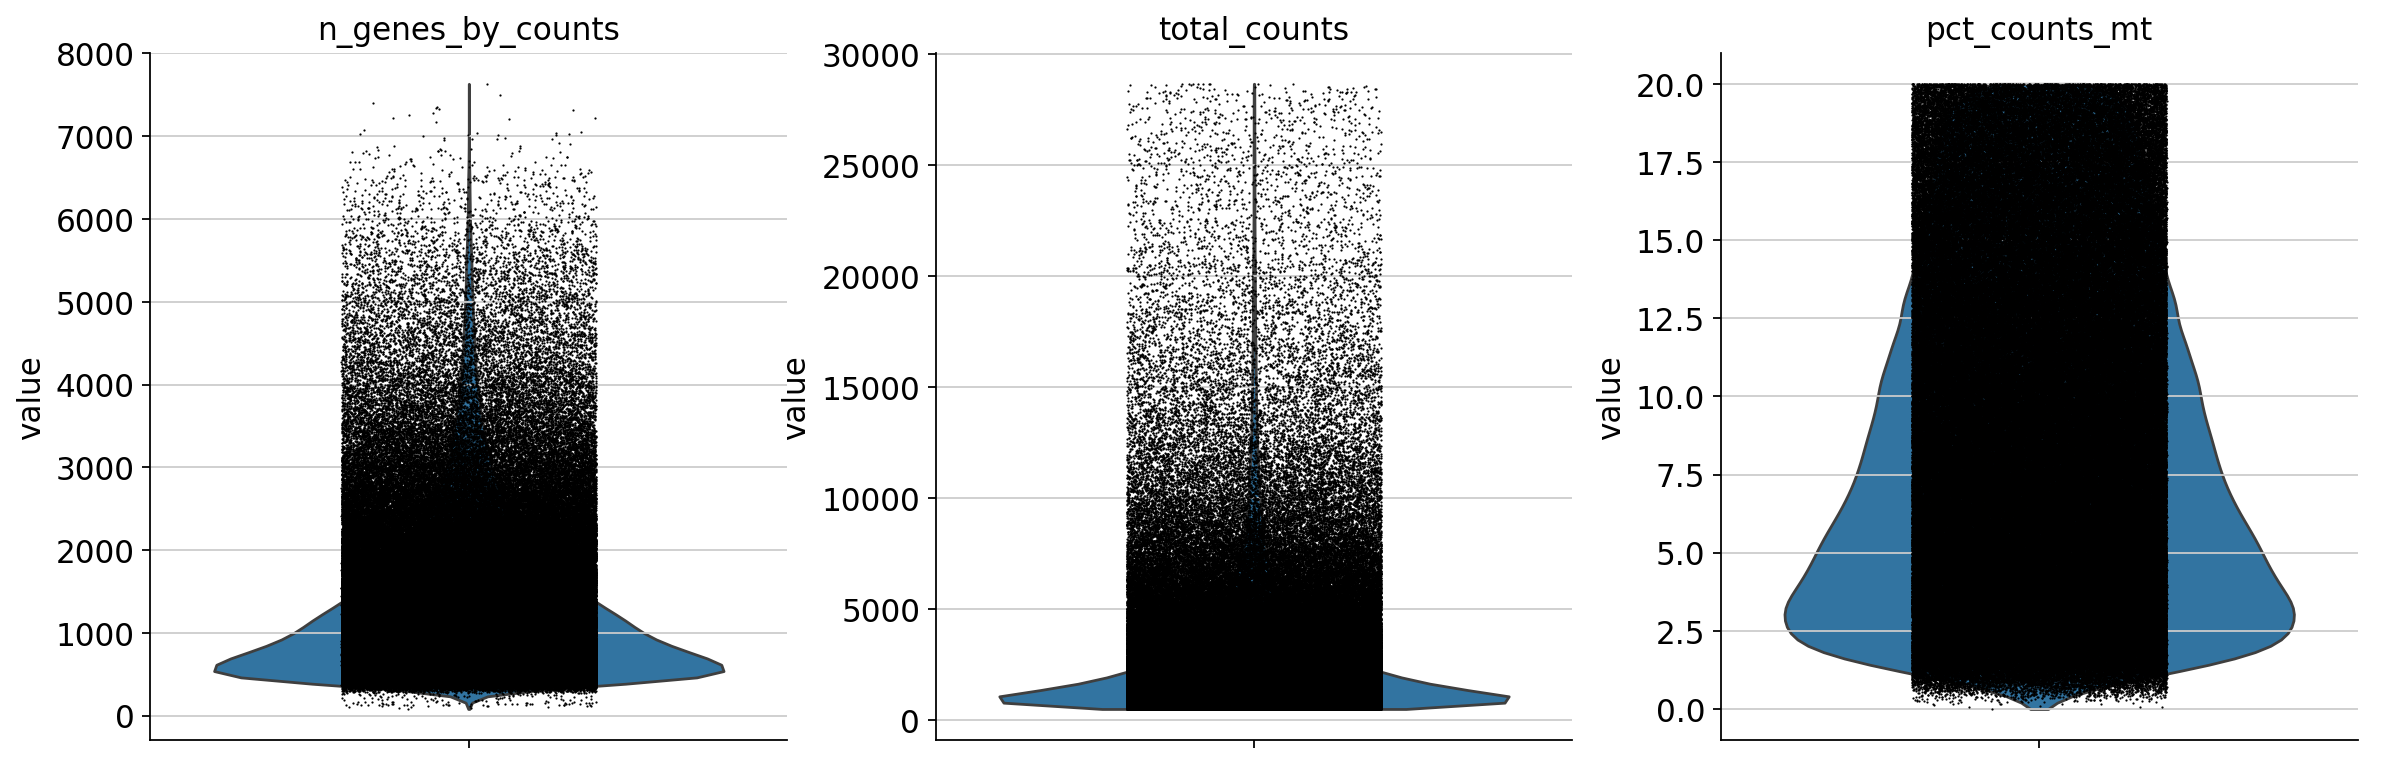

In [31]:
sc.pl.violin(
    merged_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True)

normalizing counts per cell
    finished (0:00:03)


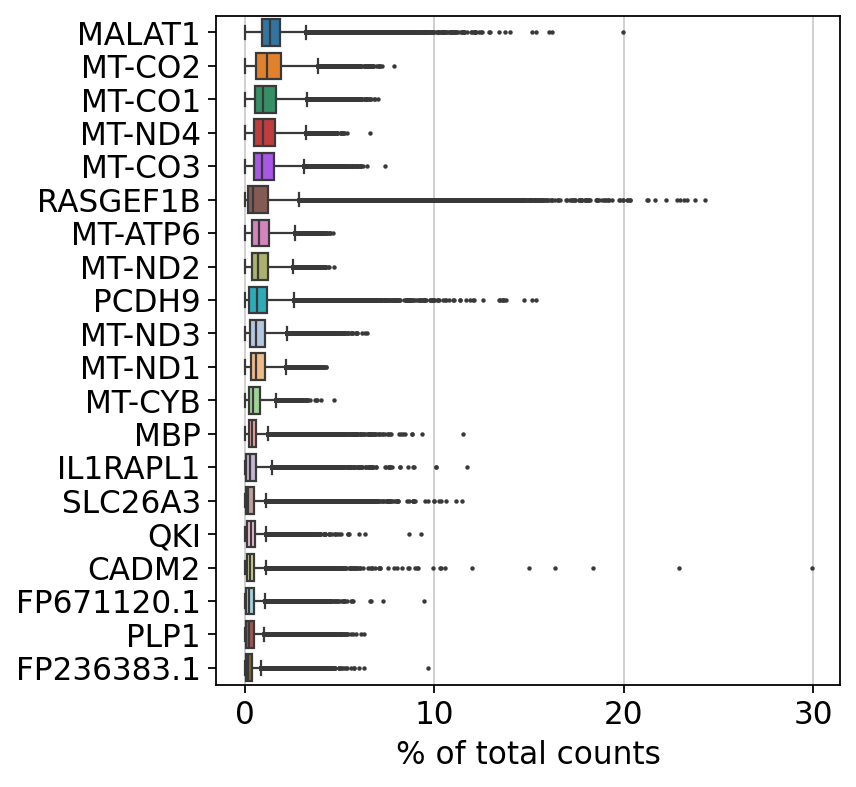

In [32]:
sc.pl.highest_expr_genes(merged_adata, n_top=20)

### **Normalization**

In [34]:
# Switch to GPU for Normalized, scaled and regressed
rsc.get.anndata_to_GPU(merged_adata)

In [36]:
merged_adata.shape

(270305, 29415)

In [35]:
rsc.pp.normalize_total(merged_adata, target_sum=1e4)

In [37]:
rsc.pp.log1p(merged_adata)

In [38]:
rsc.pp.highly_variable_genes(merged_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

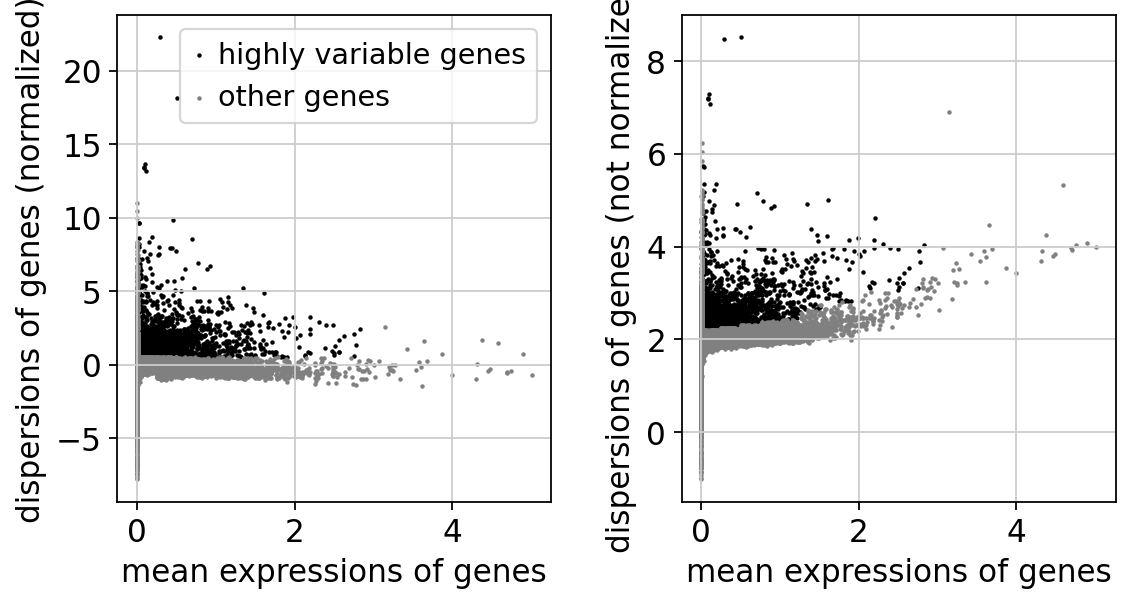

In [39]:
rsc.get.anndata_to_CPU(merged_adata)
sc.pl.highly_variable_genes(merged_adata)

**Create .raw file**

In [40]:
merged_adata.raw = merged_adata

In [41]:
merged_adata = merged_adata[:, merged_adata.var.highly_variable]

### **Regress out unwanted variable**

In [46]:
rsc.get.anndata_to_GPU(merged_adata)
rsc.pp.regress_out(merged_adata, keys=["pct_counts_mt"])

### **Scale Data**

In [47]:
rsc.pp.scale(merged_adata, max_value=10)

### **Plot PCA**

In [52]:
rsc.pp.pca(merged_adata)

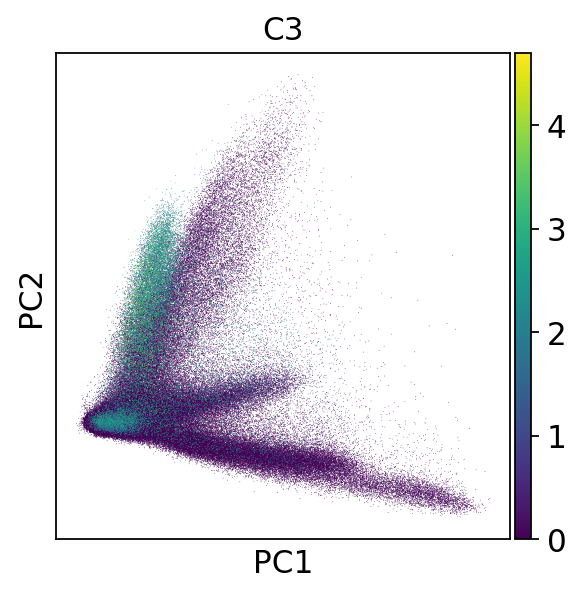

In [53]:
sc.pl.pca(merged_adata, color="C3")

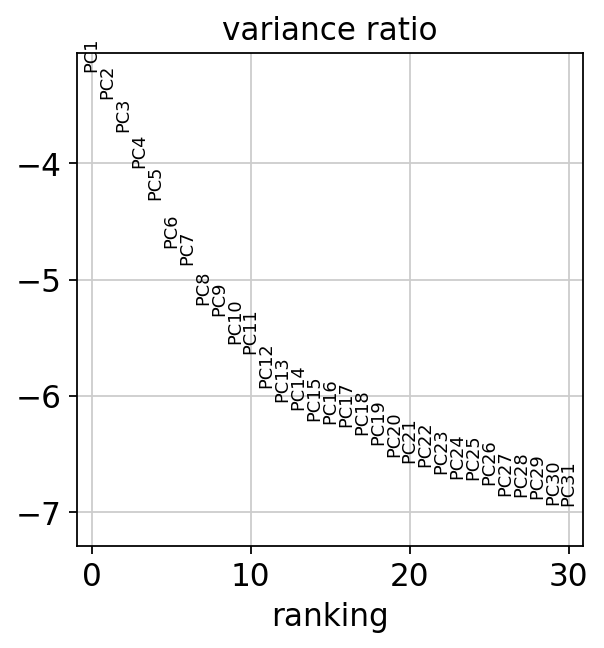

In [54]:
sc.pl.pca_variance_ratio(merged_adata, log=True)

In [55]:
merged_adata.write(results_file)

### **Find Neighbors and Plot UMAP**

In [73]:
rsc.get.anndata_to_GPU(merged_adata)
rsc.pp.neighbors(merged_adata, n_neighbors=10, n_pcs=40)

In [74]:
rsc.tl.umap(merged_adata)

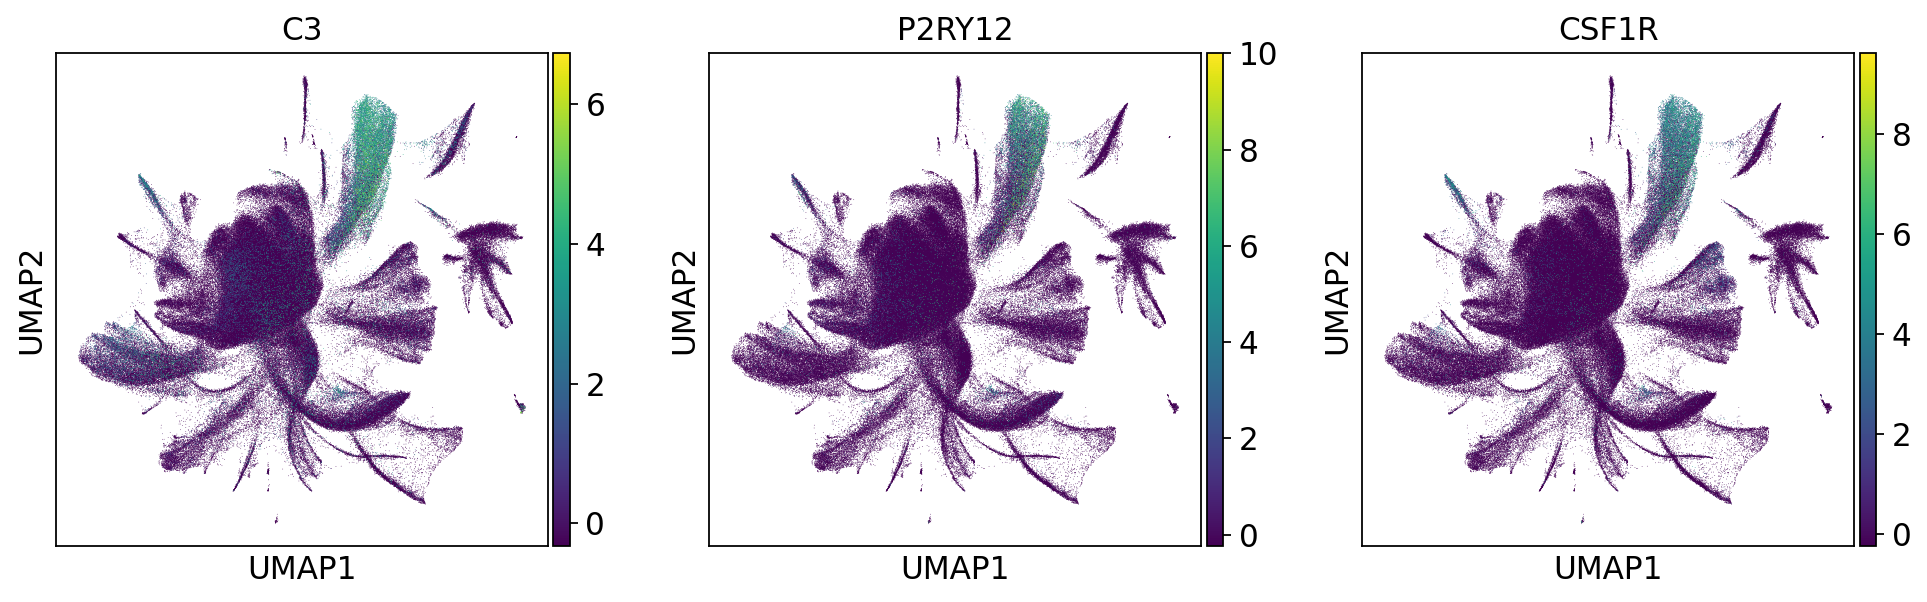

In [75]:
rsc.get.anndata_to_CPU(merged_adata)
sc.pl.umap(merged_adata, color=["C3", "P2RY12", "CSF1R"], use_raw=False)

### **Clustering**

In [79]:
rsc.get.anndata_to_GPU(merged_adata)

rsc.tl.leiden(
    merged_adata,
    resolution=0.5,
    random_state=0,
    n_iterations=2)

In [80]:
merged_adata.var_names

Index(['HES4', 'ISG15', 'FNDC10', 'GABRD', 'PRDM16', 'CHD5', 'SLC2A5',
       'PIK3CD', 'CTNNBIP1', 'UBE4B',
       ...
       'ERG', 'ETS2', 'SH3BGR', 'DSCAM', 'BACE2', 'SUMO3', 'SLC19A1', 'PCBP3',
       'COL6A2', 'MT-ND6'],
      dtype='object', length=2360)

the obs value 'leiden' has more than 103 categories. Uniform 'grey' color will be used for all categories.


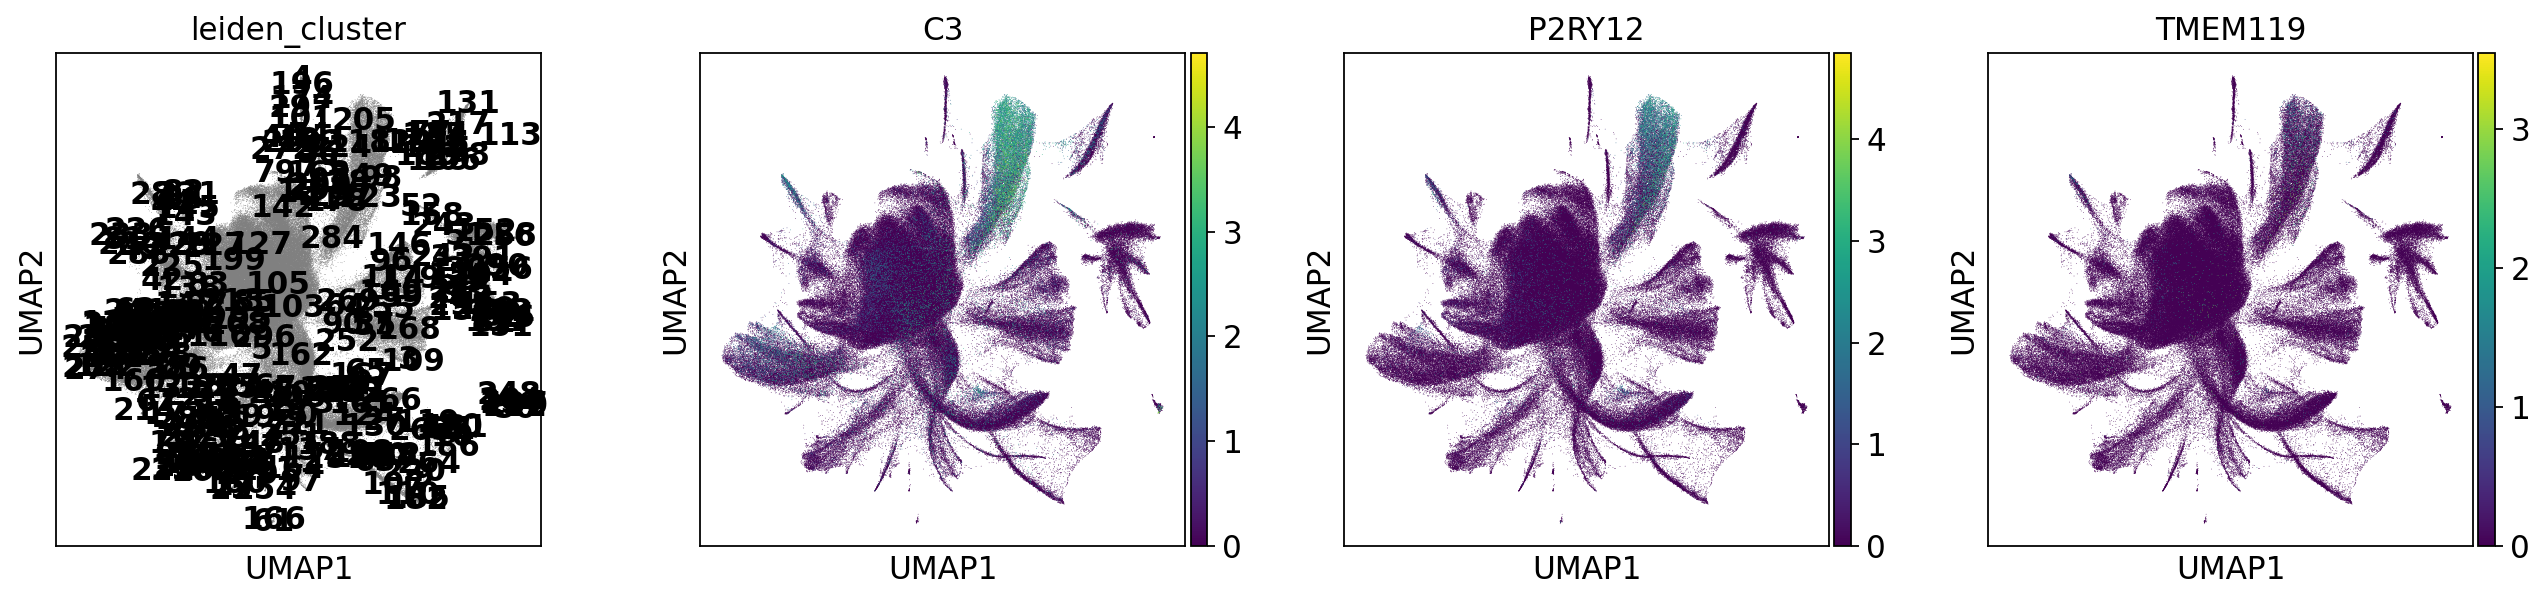

In [81]:
sc.pl.umap(merged_adata, color=["leiden", "C3", "P2RY12", "TMEM119"], legend_loc="on data", title="leiden_cluster")

In [ ]:
merged_adata.write(results_file)

### **Rank Gene Group**

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


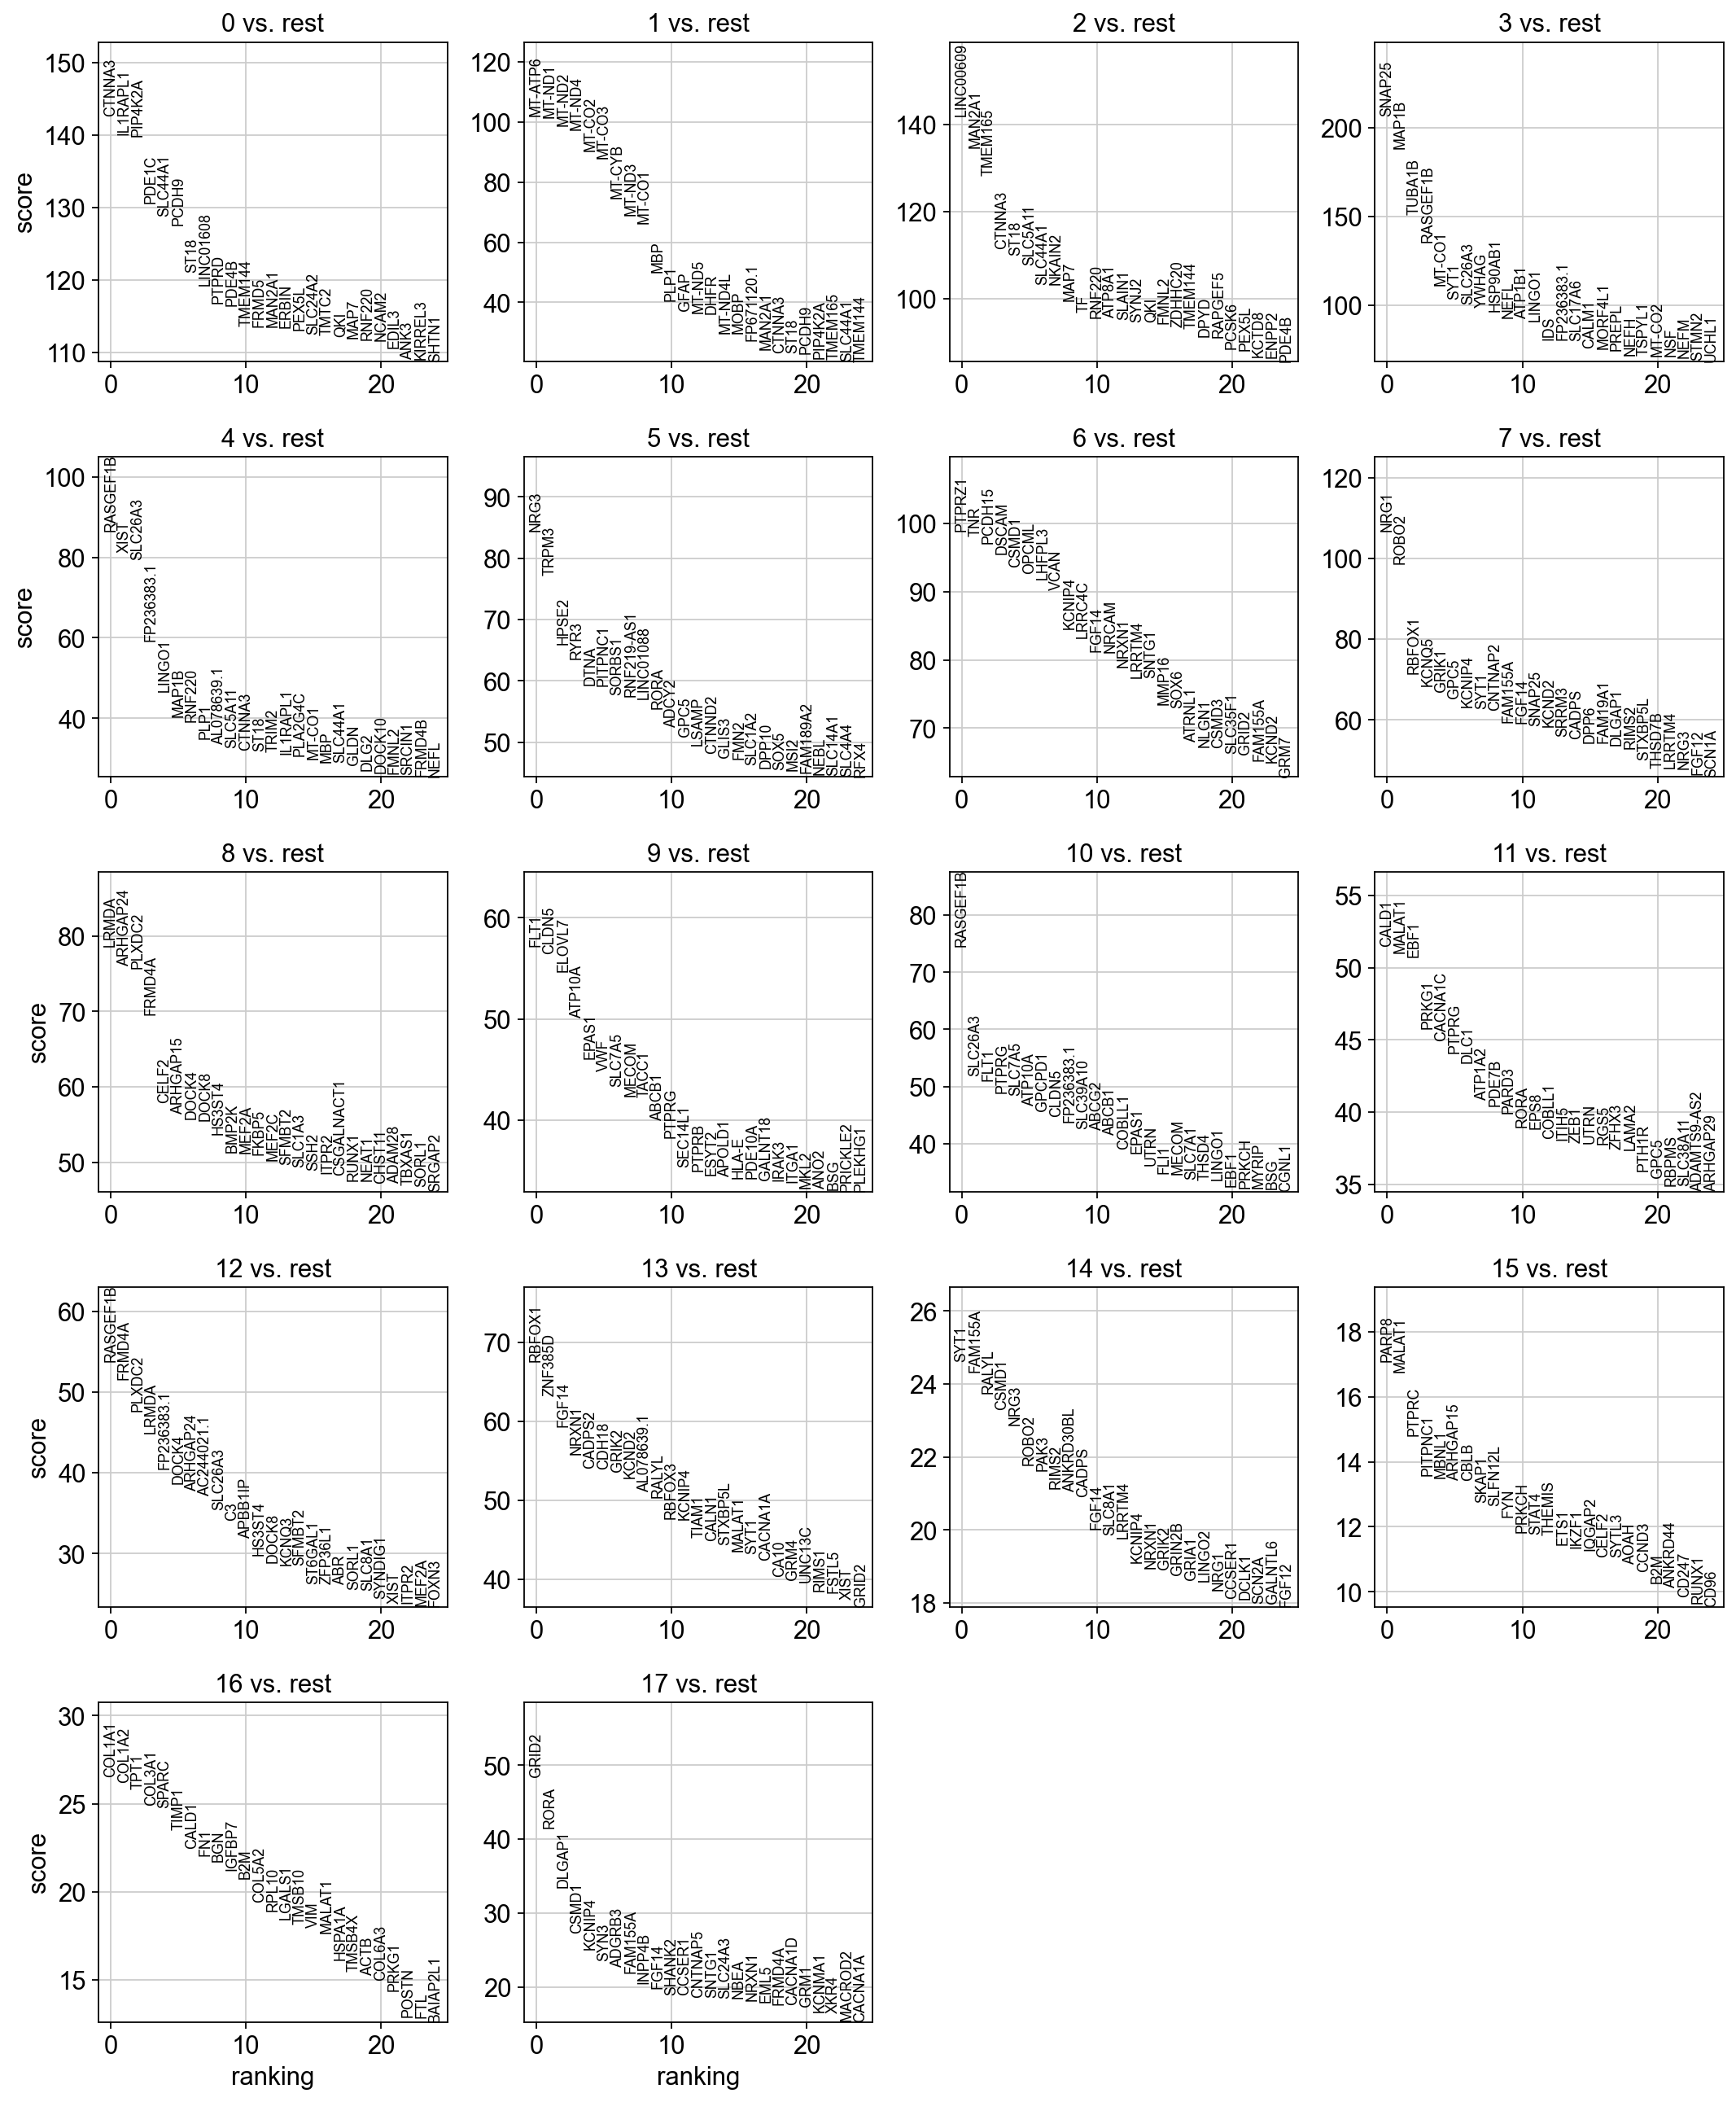

In [ ]:
# Methods can be 't-test', 't-test_overestim_var' for overreestimates varience of each group
# 'wilcoxon' for rank-sum
# 'logreg' for logistic regression

sc.tl.rank_genes_groups(merged_adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:01:30)


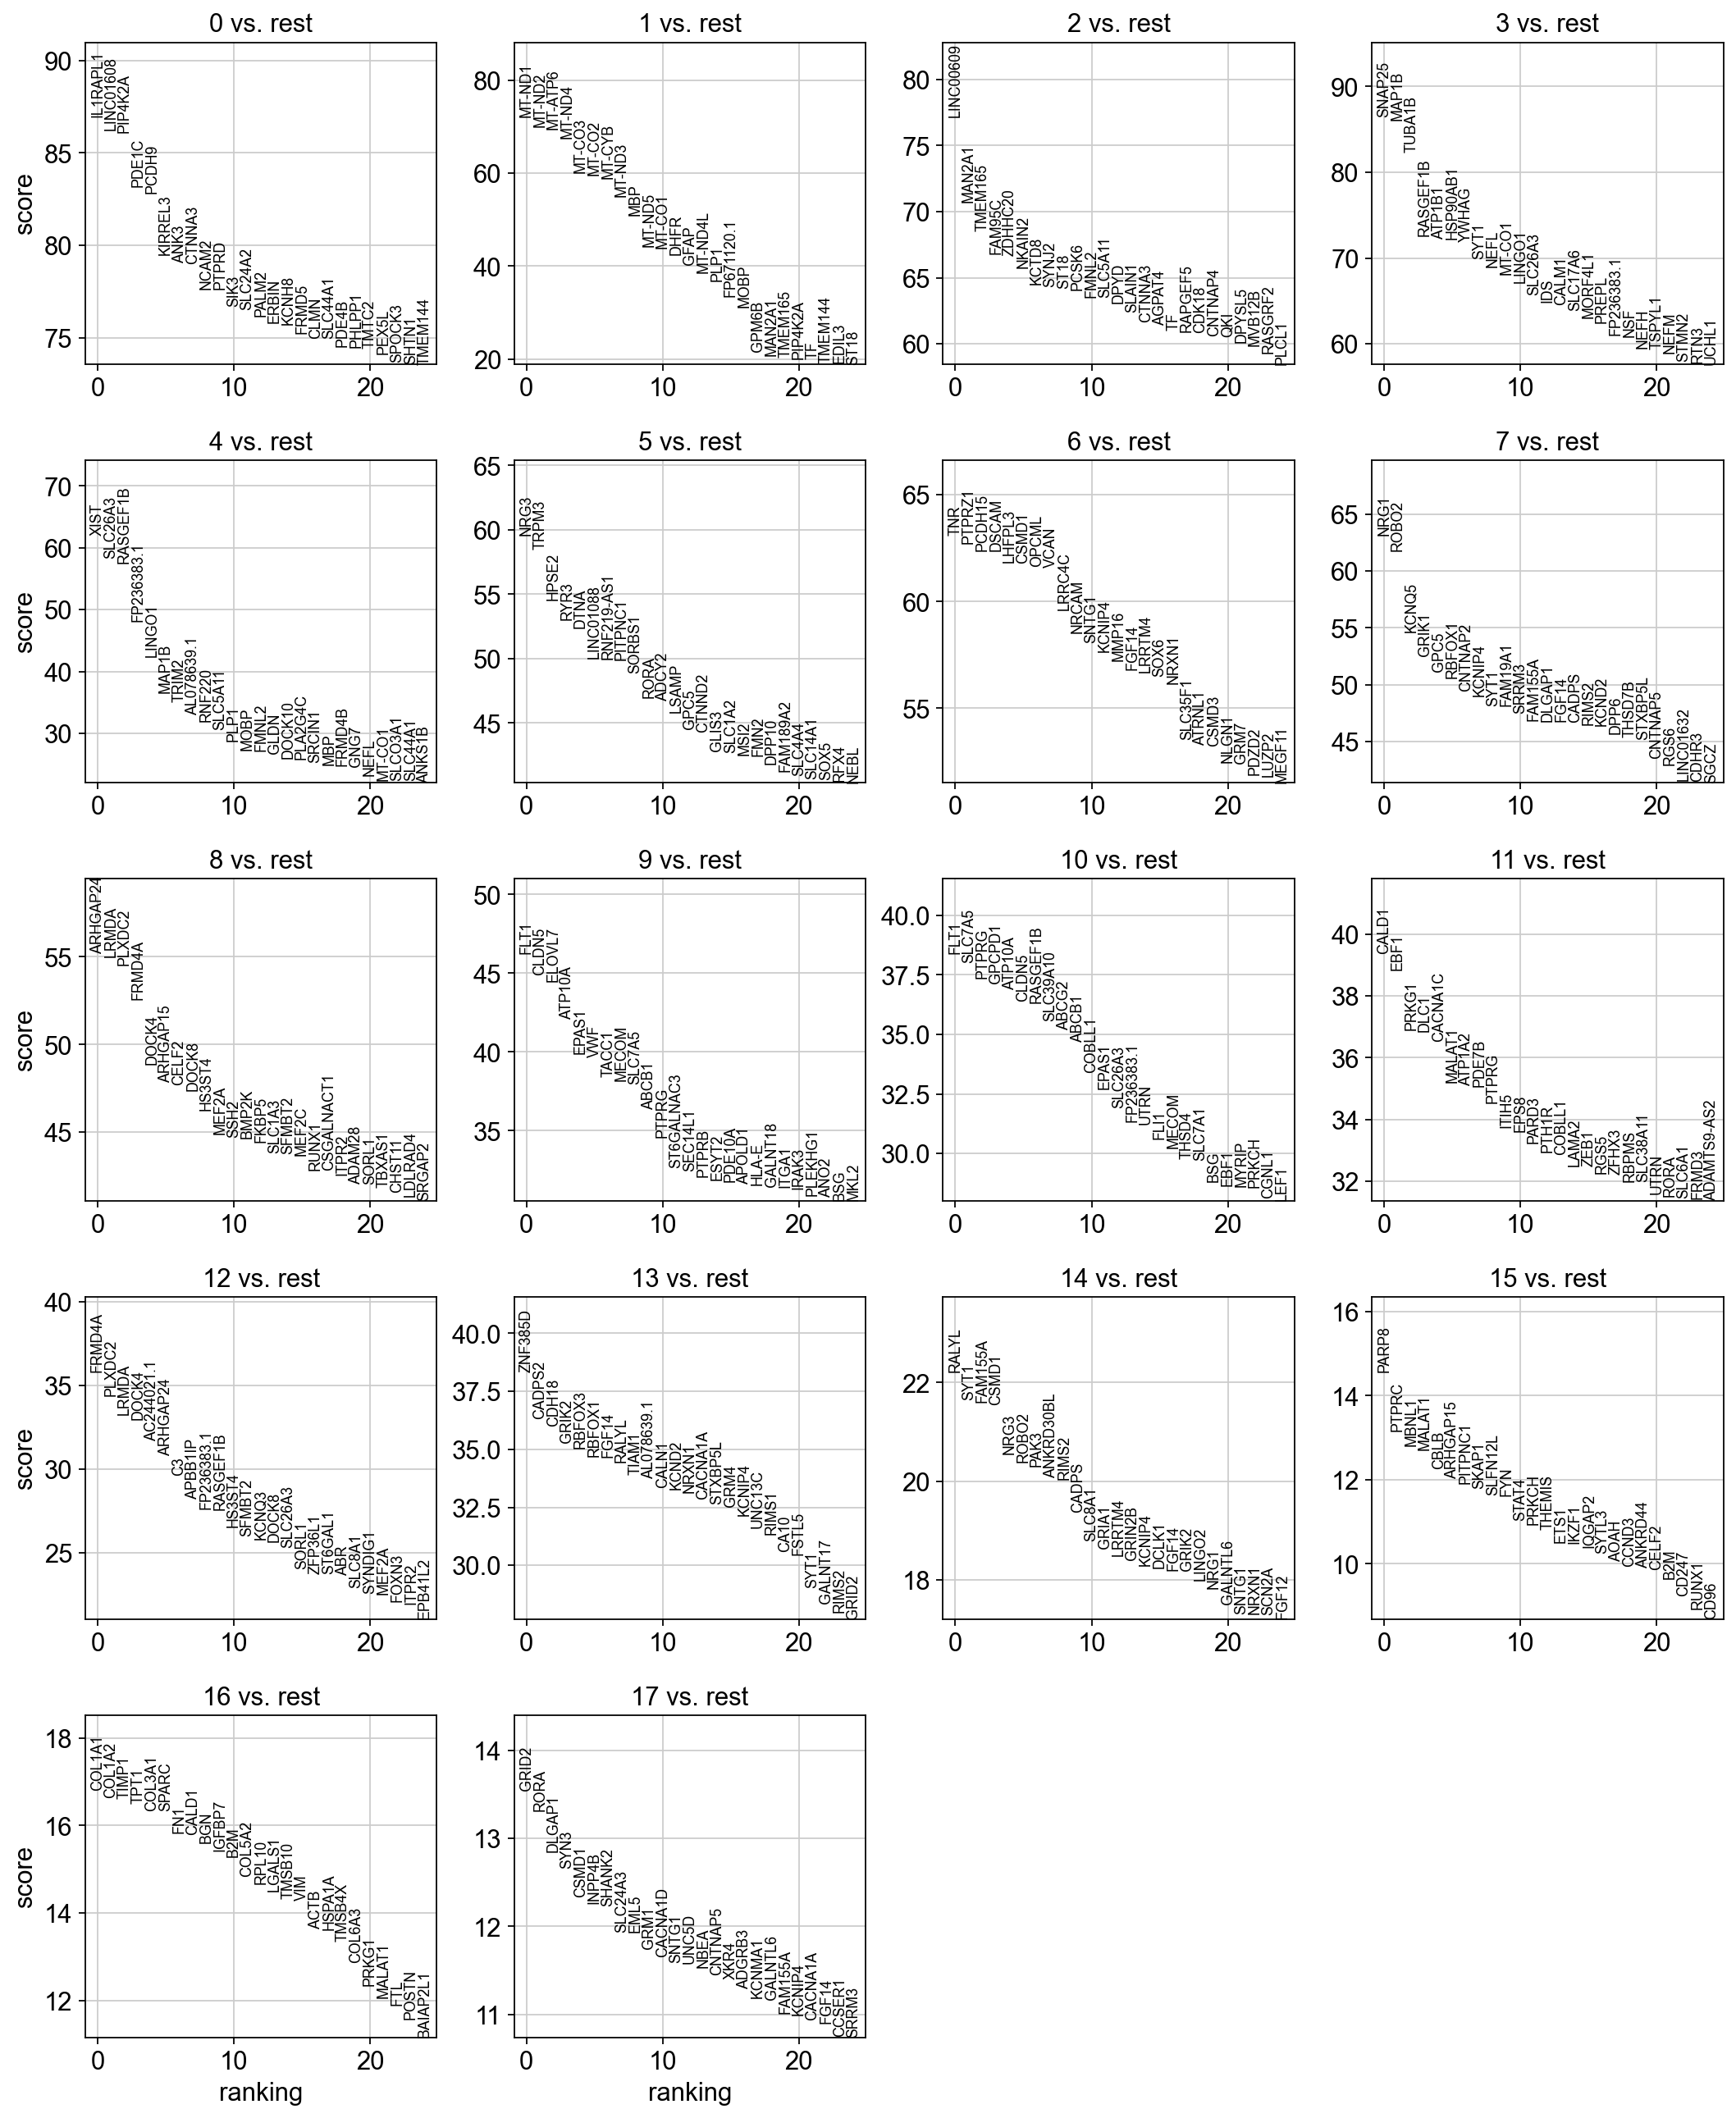

In [ ]:
sc.tl.rank_genes_groups(merged_adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [ ]:
merged_adata.write(results_file)

ranking genes
    finished (0:02:16)


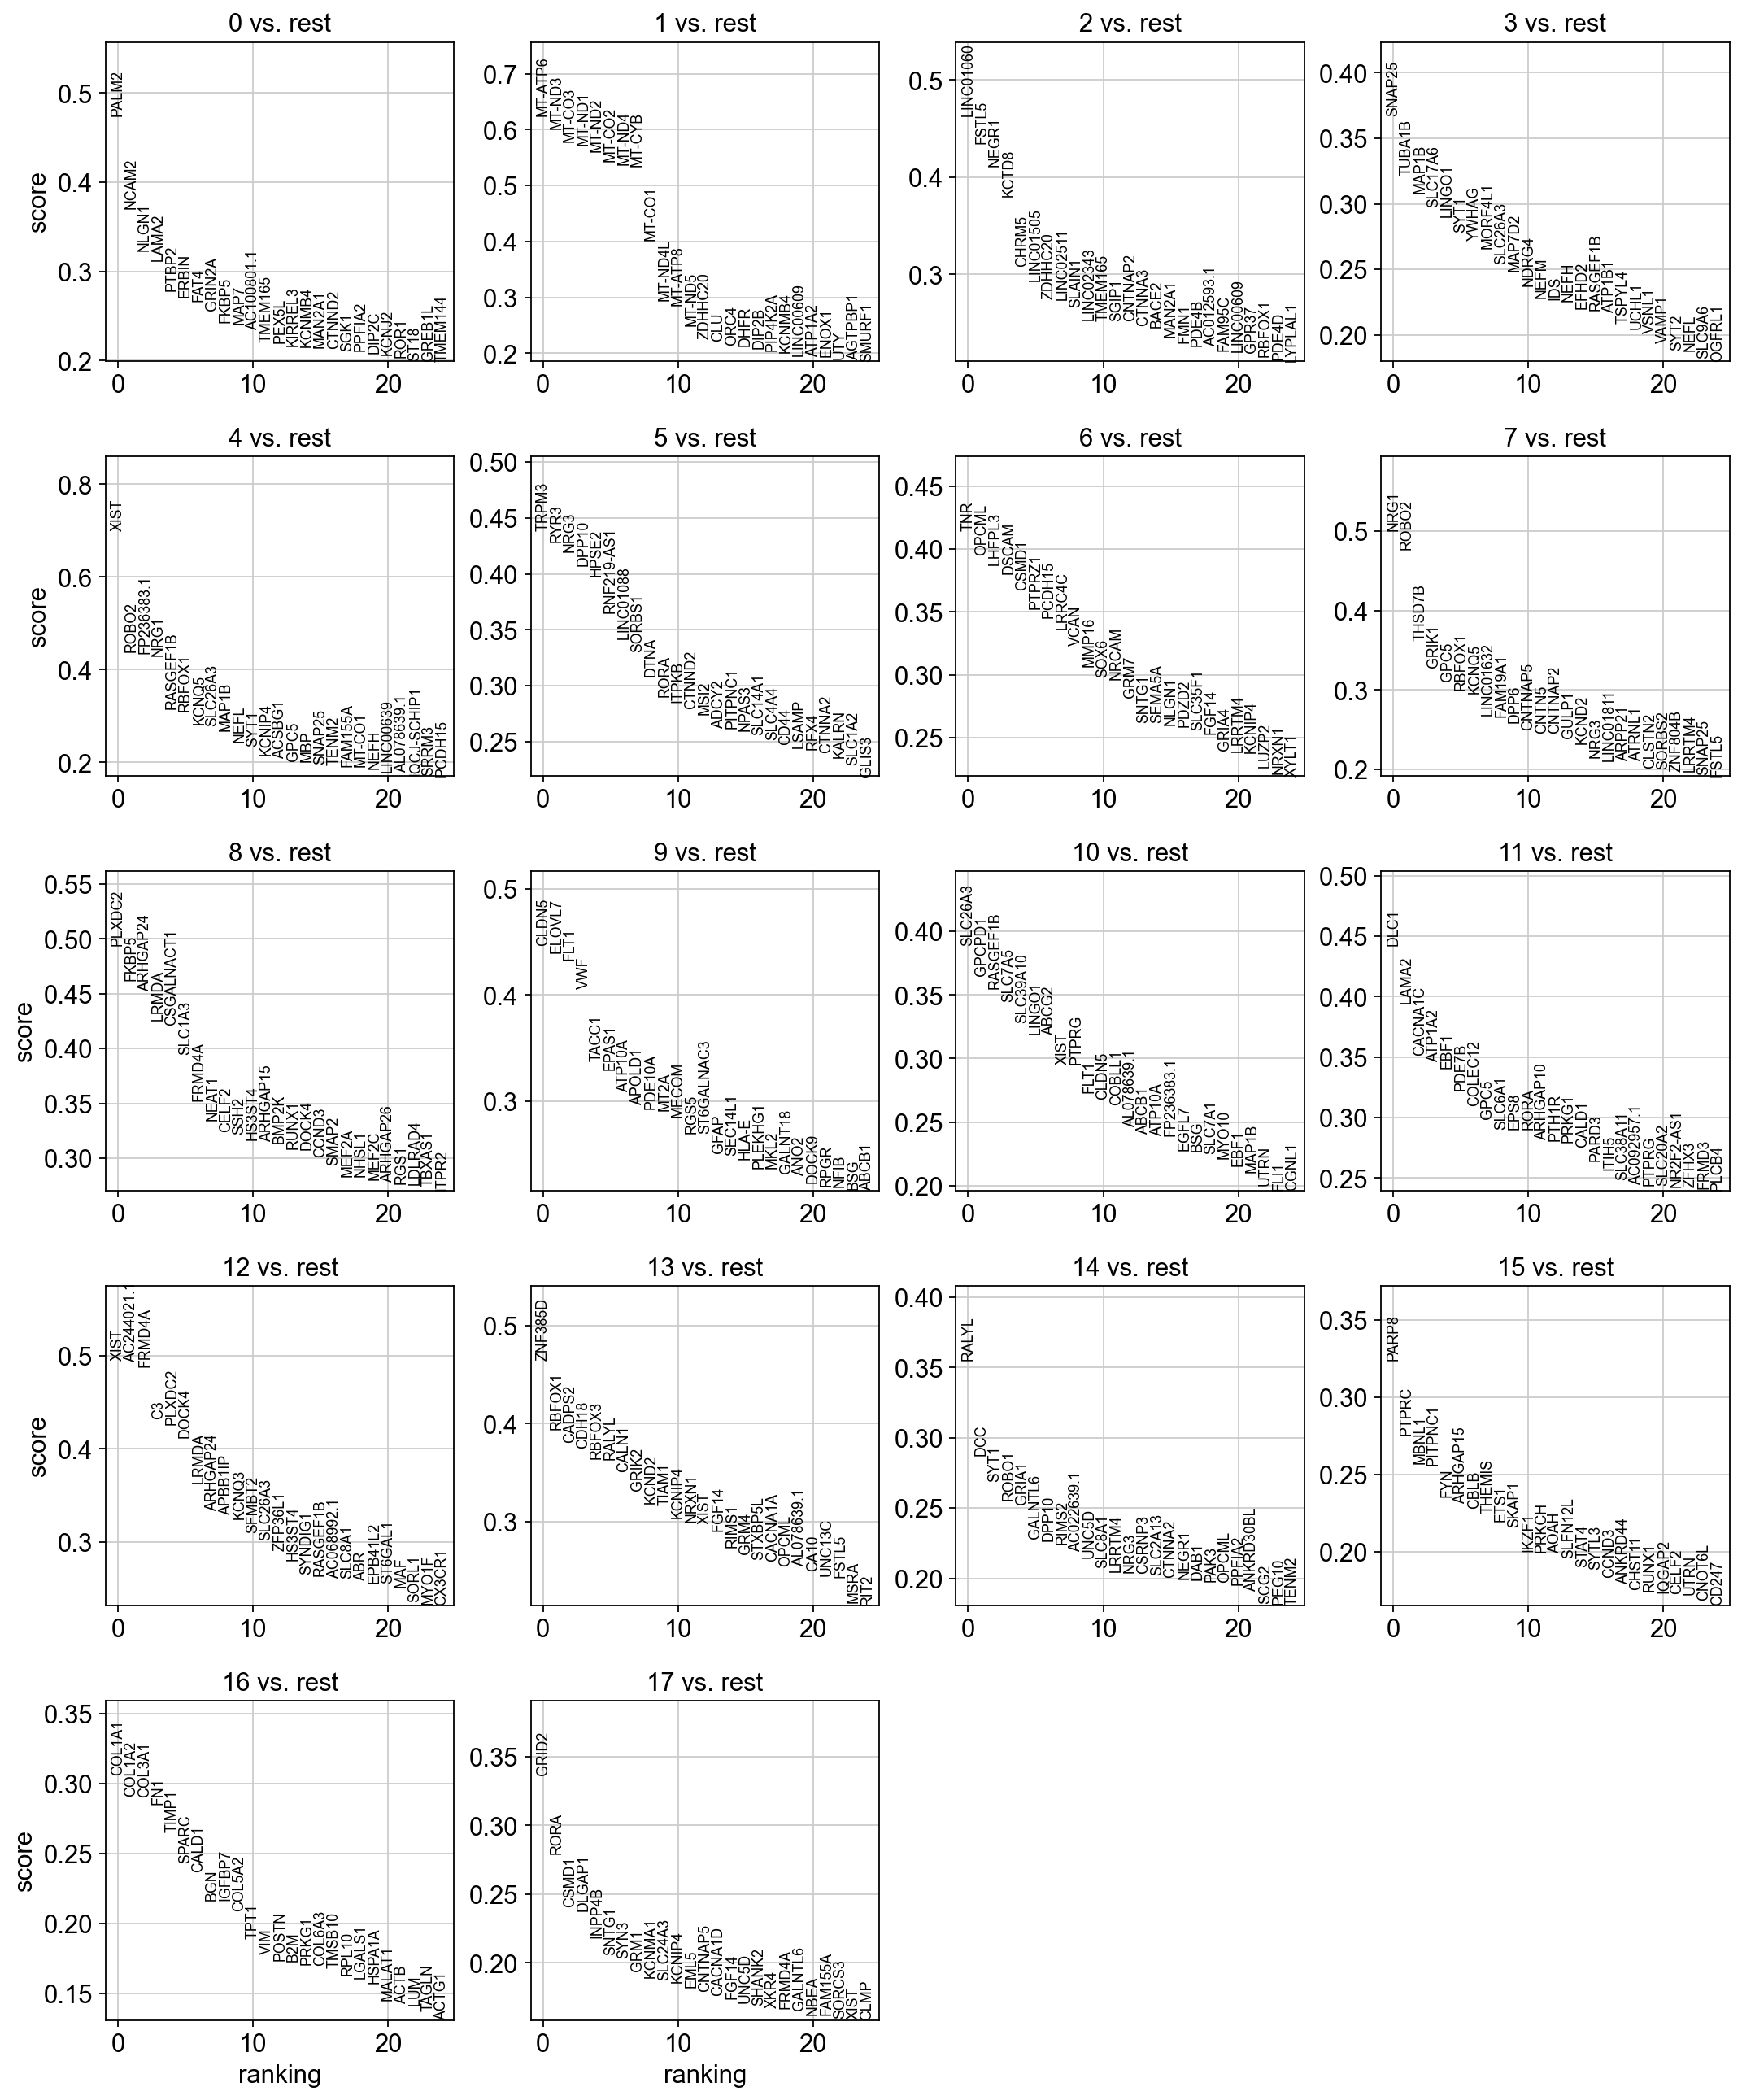

In [ ]:
sc.tl.rank_genes_groups(merged_adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(merged_adata, n_genes=25, sharey=False, ncols=4)

In [ ]:
merged_adata = sc.read(results_file)

In [ ]:
pd.DataFrame(merged_adata.uns["rank_genes_groups"]["names"]).head(10)

0        1          2         3           4           5       6  \
0   IL1RAPL1   MT-ND1  LINC00609    SNAP25        XIST        NRG3     TNR   
1  LINC01608   MT-ND2     MAN2A1     MAP1B     SLC26A3       TRPM3  PTPRZ1   
2    PIP4K2A  MT-ATP6    TMEM165    TUBA1B    RASGEF1B       HPSE2  PCDH15   
3      PDE1C   MT-ND4     FAM95C  RASGEF1B  FP236383.1        RYR3   DSCAM   
4      PCDH9   MT-CO3    ZDHHC20    ATP1B1      LINGO1        DTNA  LHFPL3   
5    KIRREL3   MT-CO2     NKAIN2  HSP90AB1       MAP1B   LINC01088   CSMD1   
6       ANK3   MT-CYB      KCTD8     YWHAG       TRIM2  RNF219-AS1   OPCML   
7     CTNNA3   MT-ND3      SYNJ2      SYT1  AL078639.1     PITPNC1    VCAN   
8      NCAM2      MBP       ST18      NEFL      RNF220      SORBS1  LRRC4C   
9      PTPRD   MT-ND5      PCSK6    MT-CO1     SLC5A11        RORA   NRCAM   

         7         8       9        10       11          12          13  \
0     NRG1  ARHGAP24    FLT1      FLT1    CALD1      FRMD4A     ZNF385D   
1    ROBO2     LRMDA   CLDN5    SLC7A5     EBF1      PLXDC2      CADPS2   
2    KCNQ5    PLXDC2  ELOVL7     PTPRG    PRKG1       LRMDA       CDH18   
3    GRIK1    FRMD4A  ATP10A    GPCPD1     DLC1       DOCK4       GRIK2   
4     GPC5     DOCK4   EPAS1    ATP10A  CACNA1C  AC244021.1      RBFOX3   
5   RBFOX1  ARHGAP15     VWF     CLDN5   MALAT1    ARHGAP24      RBFOX1   
6  CNTNAP2     CELF2   TACC1  RASGEF1B   ATP1A2          C3       FGF14   
7   KCNIP4     DOCK8   MECOM  SLC39A10    PDE7B     APBB1IP       RALYL   
8     SYT1    HS3ST4  SLC7A5     ABCG2    PTPRG  FP236383.1       TIAM1   
9  FAM19A1     MEF2A   ABCB1     ABCB1    ITIH5    RASGEF1B  AL078639.1   

          14        15      16       17  
0      RALYL     PARP8  COL1A1    GRID2  
1       SYT1     PTPRC  COL1A2     RORA  
2    FAM155A     MBNL1   TIMP1   DLGAP1  
3      CSMD1    MALAT1    TPT1     SYN3  
4       NRG3      CBLB  COL3A1    CSMD1  
5      ROBO2  ARHGAP15   SPARC   INPP4B  
6       PAK3   PITPNC1     FN1   SHANK2  
7  ANKRD30BL     SKAP1   CALD1  SLC24A3  
8      RIMS2   SLFN12L     BGN     EML5  
9      CADPS       FYN  IGFBP7     GRM1

In [ ]:
result = merged_adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(10)

0_n  0_p      1_n  1_p        2_n  2_p       3_n  3_p         4_n  \
0   IL1RAPL1  0.0   MT-ND1  0.0  LINC00609  0.0    SNAP25  0.0        XIST   
1  LINC01608  0.0   MT-ND2  0.0     MAN2A1  0.0     MAP1B  0.0     SLC26A3   
2    PIP4K2A  0.0  MT-ATP6  0.0    TMEM165  0.0    TUBA1B  0.0    RASGEF1B   
3      PDE1C  0.0   MT-ND4  0.0     FAM95C  0.0  RASGEF1B  0.0  FP236383.1   
4      PCDH9  0.0   MT-CO3  0.0    ZDHHC20  0.0    ATP1B1  0.0      LINGO1   
5    KIRREL3  0.0   MT-CO2  0.0     NKAIN2  0.0  HSP90AB1  0.0       MAP1B   
6       ANK3  0.0   MT-CYB  0.0      KCTD8  0.0     YWHAG  0.0       TRIM2   
7     CTNNA3  0.0   MT-ND3  0.0      SYNJ2  0.0      SYT1  0.0  AL078639.1   
8      NCAM2  0.0      MBP  0.0       ST18  0.0      NEFL  0.0      RNF220   
9      PTPRD  0.0   MT-ND5  0.0      PCSK6  0.0    MT-CO1  0.0     SLC5A11   

             4_p  ...        13_n           13_p       14_n           14_p  \
0   0.000000e+00  ...     ZNF385D   0.000000e+00      RALYL  2.117197e-109   
1   0.000000e+00  ...      CADPS2  3.153279e-289       SYT1  6.746573e-104   
2   0.000000e+00  ...       CDH18  3.517799e-284    FAM155A  1.608583e-103   
3   0.000000e+00  ...       GRIK2  3.378116e-273      CSMD1  5.045723e-103   
4   0.000000e+00  ...      RBFOX3  2.989090e-269       NRG3   6.263017e-94   
5  3.241068e-293  ...      RBFOX1  5.750839e-264      ROBO2   2.174823e-92   
6  2.683454e-270  ...       FGF14  2.389015e-263       PAK3   1.281814e-91   
7  1.231033e-239  ...       RALYL  4.965366e-260  ANKRD30BL   1.260273e-89   
8  2.438747e-224  ...       TIAM1  4.115989e-252      RIMS2   2.919973e-89   
9  6.819228e-206  ...  AL078639.1  8.688580e-250      CADPS   1.391597e-83   

       15_n          15_p    16_n          16_p     17_n          17_p  
0     PARP8  3.931648e-48  COL1A1  1.906019e-63    GRID2  7.736138e-42  
1     PTPRC  1.309841e-39  COL1A2  3.500406e-62     RORA  1.775960e-40  
2     MBNL1  1.562732e-37   TIMP1  5.396432e-62   DLGAP1  8.471650e-38  
3    MALAT1  4.708806e-37    TPT1  3.310848e-61     SYN3  9.910746e-37  
4      CBLB  1.514250e-34  COL3A1  5.001480e-60    CSMD1  5.481708e-35  
5  ARHGAP15  2.310378e-33   SPARC  5.692531e-60   INPP4B  1.492724e-34  
6   PITPNC1  1.088204e-32     FN1  1.849551e-56   SHANK2  2.034440e-34  
7     SKAP1  4.304779e-32   CALD1  3.632343e-56  SLC24A3  7.868160e-33  
8   SLFN12L  2.654808e-31     BGN  6.653718e-55     EML5  7.900977e-33  
9       FYN  2.871972e-31  IGFBP7  1.099916e-53     GRM1  7.020283e-32  

[10 rows x 36 columns]

ranking genes
    finished (0:00:09)


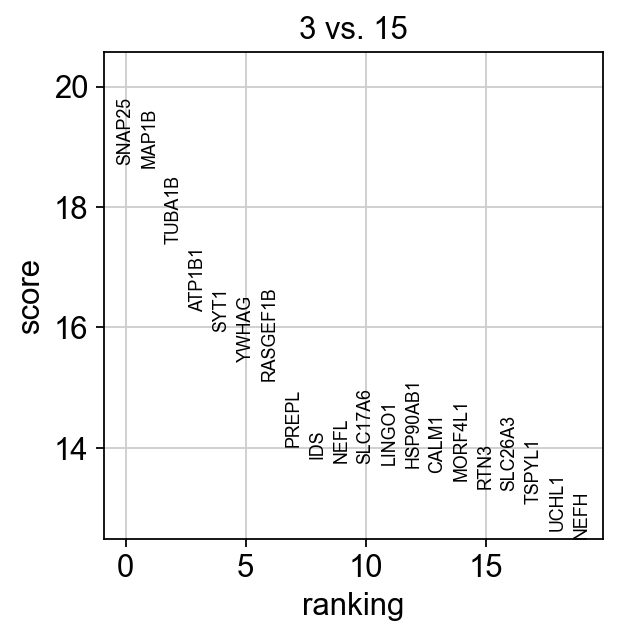

In [ ]:
sc.tl.rank_genes_groups(merged_adata, "leiden", groups=["3"], reference="15", method="wilcoxon")
sc.pl.rank_genes_groups(merged_adata, groups=["3"], n_genes=20)

In [ ]:
merged_adata = sc.read(results_file)

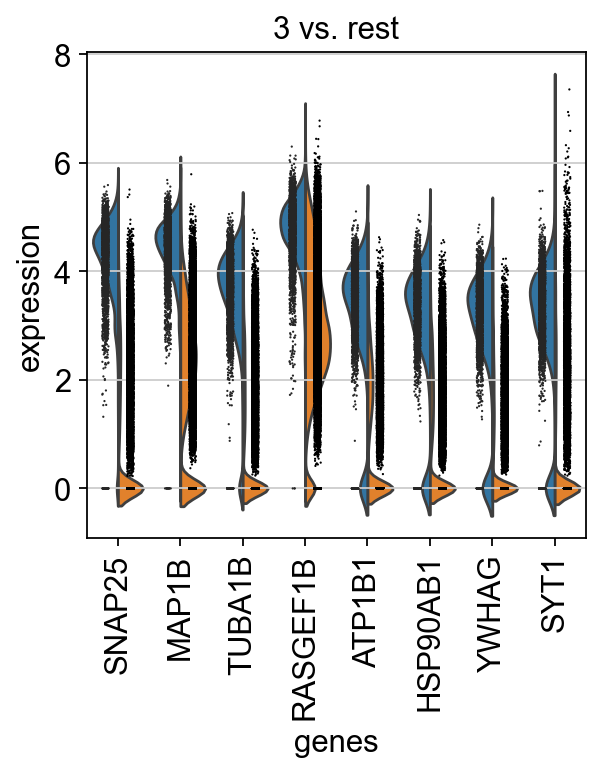

In [ ]:
sc.pl.rank_genes_groups_violin(merged_adata, groups="3", n_genes=8)

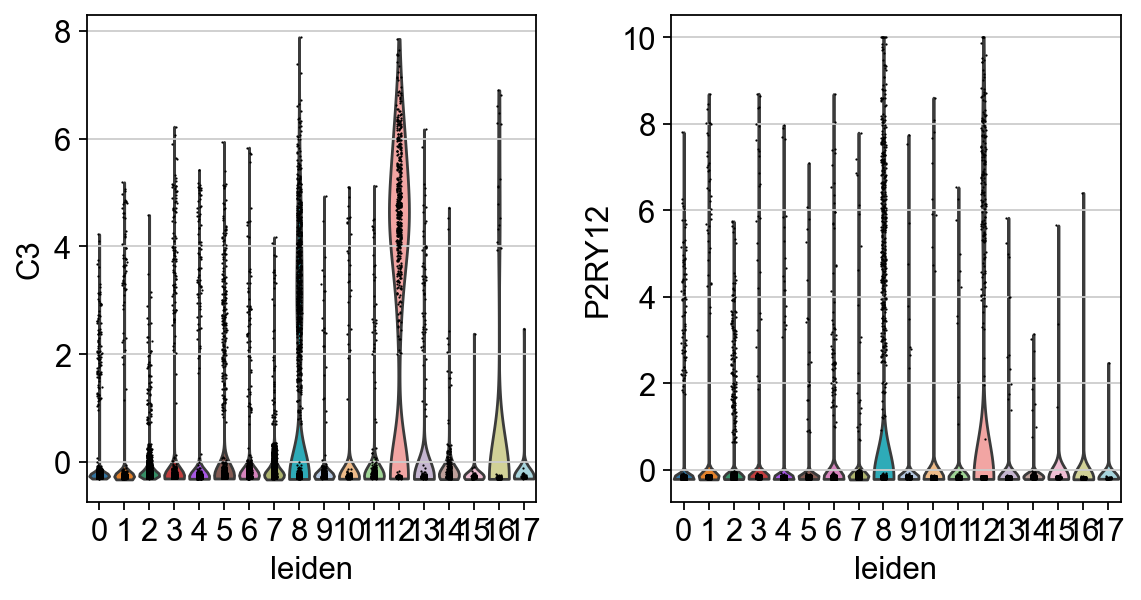

In [ ]:
sc.pl.violin(merged_adata, ["C3", "P2RY12"], groupby= "leiden", use_raw=False)